In [1]:
%load_ext autoreload
%autoreload 2

import pprint
from typing import OrderedDict

import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision.datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

import models.resnet
import models.resnet_dropout
import models.unet_model
import utils.detection_metrics
import utils.metrics
import utils.model
import utils.visualisations
from utils.detection_utils import calculate_mAP
from pprint import PrettyPrinter



from utils.temperature_scaling import ModelWithTemperature

from datasets.voc_detection_dataset import PascalVOCDataset


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
# model = torchvision.models.detection.ssd300_vgg16(


#     pretrained=True, trainable_backbone_layers=0)



model = torch.load("checkpoints/ssd300.pt")
model.to(device)


SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [6]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

test_dataset = PascalVOCDataset("VOC",
                                split='test',
                                keep_difficult=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                          collate_fn=test_dataset.collate_fn)

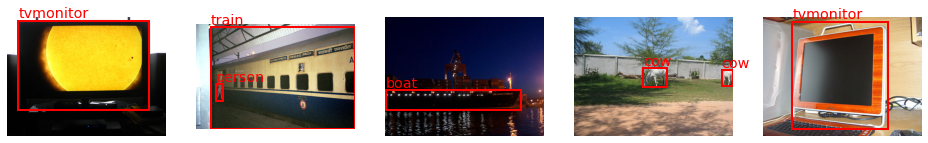

In [36]:
import matplotlib.patches as patches


num = 5
fig, axs = plt.subplots(1, num, figsize=(13,3), squeeze=False)
for i in range(num):
    axs[0][i].imshow(data_test[i][0].permute((1,2,0)))
    axs[0][i].axis("off")

    meta = data_test[i][1]
    for j in range(len(meta["labels"])):
        box = meta["boxes"][j]
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        axs[0][i].text(box[0], box[1] - 10 , VOC_CLASSES[int(meta["labels"][j])], c="red", fontsize="x-large")
        axs[0][i].add_patch(rect)

        
    # axs[1][i].imshow(decode_segmap(data_test[i][1]))
    # axs[1][i].axis("off")
plt.tight_layout()
plt.savefig("figures/voc-detection-examples.pdf")

In [26]:
pp = PrettyPrinter()


model.to(device)
model.eval()

# Lists to store detected and true boxes, labels, scores
det_boxes = list()
det_labels = list()
det_scores = list()
true_boxes = list()
true_labels = list()
# it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py
true_difficulties = list()

with torch.no_grad():
    # Batches
    for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
        images = images.to(device)  # (N, 3, 300, 300)

        # Forward prop.
        predicted_locs, predicted_scores = model(images)

        # Detect objects in SSD output
        det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                    min_score=0.2, max_overlap=0.5,
                                                                                    top_k=200)
        # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

        # Store this batch's results for mAP calculation
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        difficulties = [d.to(device) for d in difficulties]

        det_boxes.extend(det_boxes_batch)
        det_labels.extend(det_labels_batch)
        det_scores.extend(det_scores_batch)
        true_boxes.extend(boxes)
        true_labels.extend(labels)
        true_difficulties.extend(difficulties)

    # Calculate mAP
    APs, mAP = calculate_mAP(
        det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.5)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP) 50: %.3f' % mAP)

    APs, mAP = calculate_mAP(
    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 0.75)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP) 75: %.3f' % mAP)

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]/home/jirka/uncertainty_estimations/models/ssd_300.py:567: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/jirka/uncertainty_estimations/models/ssd_300.py:570: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100%|██████████| 155/155 [01:08<00:00,  2.27it/s]


{'aeroplane': 0.714512825012207,
 'bicycle': 0.8037384152412415,
 'bird': 0.7025646567344666,
 'boat': 0.7234222888946533,
 'bottle': 0.4195532500743866,
 'bus': 0.8035459518432617,
 'car': 0.8033244013786316,
 'cat': 0.8105748295783997,
 'chair': 0.5317335724830627,
 'cow': 0.7693753838539124,
 'diningtable': 0.7283228039741516,
 'dog': 0.7954436540603638,
 'horse': 0.8813306093215942,
 'motorbike': 0.8018825054168701,
 'person': 0.7645366191864014,
 'pottedplant': 0.5050734281539917,
 'sheep': 0.7683832049369812,
 'sofa': 0.7669880986213684,
 'train': 0.8030271530151367,
 'tvmonitor': 0.7429261803627014}

Mean Average Precision (mAP) 50: 0.732
{'aeroplane': 0.5745320916175842,
 'bicycle': 0.6030123829841614,
 'bird': 0.47294852137565613,
 'boat': 0.4077630937099457,
 'bottle': 0.20680640637874603,
 'bus': 0.7127574682235718,
 'car': 0.6145771145820618,
 'cat': 0.6564734578132629,
 'chair': 0.2928912043571472,
 'cow': 0.5333989262580872,
 'diningtable': 0.4672670364379883,
 'dog': 0.5

In [77]:
det_boxes[0], det_labels[0], det_scores[0], true_boxes[0], true_labels[0]

(tensor([[0.0577, 0.4452, 0.5921, 0.8522],
         [0.0187, 0.0078, 0.9949, 0.9959]], device='cuda:0'),
 tensor([12, 15], device='cuda:0'),
 tensor([0.7084, 0.9990], device='cuda:0'),
 tensor([[0.1331, 0.4780, 0.5496, 0.7400],
         [0.0198, 0.0220, 0.9943, 0.9940]], device='cuda:0'),
 tensor([12, 15], device='cuda:0'))

In [45]:
from utils.detection_utils import find_jaccard_overlap
ious = find_jaccard_overlap(det_boxes[0], true_boxes[0])

for i in ious:
    print(i)


tensor([0.0000, 0.0123], device='cuda:0')
tensor([0.0000, 0.0245], device='cuda:0')
tensor([0.1949, 0.5631], device='cuda:0')
tensor([0.0000, 0.0111], device='cuda:0')
tensor([0.0000, 0.0291], device='cuda:0')
tensor([0.0000, 0.0234], device='cuda:0')
tensor([0.0000, 0.0124], device='cuda:0')
tensor([0.0000, 0.0097], device='cuda:0')
tensor([0.0225, 0.0308], device='cuda:0')
tensor([0.5017, 0.2296], device='cuda:0')
tensor([0.1949, 0.5631], device='cuda:0')
tensor([0.2626, 0.1876], device='cuda:0')
tensor([0.1131, 0.9819], device='cuda:0')
tensor([0.0000, 0.0094], device='cuda:0')
tensor([0.0000, 0.0089], device='cuda:0')
tensor([0.0000, 0.0211], device='cuda:0')
tensor([0.0000, 0.0222], device='cuda:0')
tensor([0.1949, 0.5631], device='cuda:0')


In [110]:
from utils.detection_utils import find_jaccard_overlap

def classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels, iou_threshold=0.5):
    TP = []
    FP = []
    FN = []

    for img_idx, (bboxes, labels, scores, gt, gt_labels) in enumerate(zip(det_boxes, det_labels, det_scores, true_boxes, true_labels)):
        idx = torch.argsort(scores, descending=True)
        ious = find_jaccard_overlap(bboxes, gt)
        matched_gt_indexes = []
        matched_boxes_indexes = []
        for true_boxes_iou, box_idx in zip(ious[idx], idx):
            best_iou = 0
            best_iou_idx = None
            for true_boxes_idx, iou in enumerate(true_boxes_iou):
                if iou > best_iou and labels[box_idx] == gt_labels[true_boxes_idx] and true_boxes_idx not in matched_gt_indexes:
                    best_iou = iou
                    best_iou_idx = true_boxes_idx
            if best_iou > iou_threshold:
                TP.append((img_idx,box_idx.item()))
                matched_gt_indexes.append(best_iou_idx)
                matched_boxes_indexes.append(box_idx.item())
        for i, box in enumerate(gt):
            if i not in matched_gt_indexes:
                FN.append((img_idx,i))
        for i, box in enumerate(bboxes):
            if i not in matched_boxes_indexes:
                FP.append((img_idx,i))
    return TP, FP, FN

In [111]:
TP, FP, FN = classify_boxes(det_boxes, det_labels, det_scores, true_boxes, true_labels)

In [97]:
len(TP), len(FP), len(FN)

(10463, 5904, 4513)

In [9]:
import matplotlib.patches as patches

def plot_image(image, boxes, gt_boxes):
    """Plots predicted bounding boxes on the image"""
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1,2,0))
    im = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height
    img_shape = torch.tensor([300,300,300,300]).to(device)
    # Create a Rectangle potch
    for box in boxes:
        box = (box * img_shape).cpu()
        # cls = box[1]
        # confidence = box[2]
        # box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5,
            edgecolor="r",
            facecolor="none"
        )
        # plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="r")
        # Add the patch to the Axes
        ax.add_patch(rect)

    for box in gt_boxes:
        box = (box * img_shape).cpu()
        # cls = box[1]
        # box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5,
            edgecolor="g",
            facecolor="none"

        )
        # plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="g")

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [101]:
TP

[(0, tensor(1, device='cuda:0')),
 (0, tensor(0, device='cuda:0')),
 (1, tensor(0, device='cuda:0')),
 (3, tensor(0, device='cuda:0')),
 (3, tensor(1, device='cuda:0')),
 (3, tensor(2, device='cuda:0')),
 (3, tensor(3, device='cuda:0')),
 (3, tensor(4, device='cuda:0')),
 (3, tensor(5, device='cuda:0')),
 (4, tensor(4, device='cuda:0')),
 (4, tensor(0, device='cuda:0')),
 (4, tensor(1, device='cuda:0')),
 (5, tensor(0, device='cuda:0')),
 (6, tensor(1, device='cuda:0')),
 (6, tensor(0, device='cuda:0')),
 (7, tensor(0, device='cuda:0')),
 (8, tensor(0, device='cuda:0')),
 (9, tensor(1, device='cuda:0')),
 (9, tensor(0, device='cuda:0')),
 (9, tensor(3, device='cuda:0')),
 (9, tensor(2, device='cuda:0')),
 (9, tensor(4, device='cuda:0')),
 (10, tensor(0, device='cuda:0')),
 (11, tensor(0, device='cuda:0')),
 (12, tensor(0, device='cuda:0')),
 (12, tensor(1, device='cuda:0')),
 (13, tensor(4, device='cuda:0')),
 (13, tensor(5, device='cuda:0')),
 (13, tensor(7, device='cuda:0')),
 (13, t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 14


TypeError: iteration over a 0-d tensor

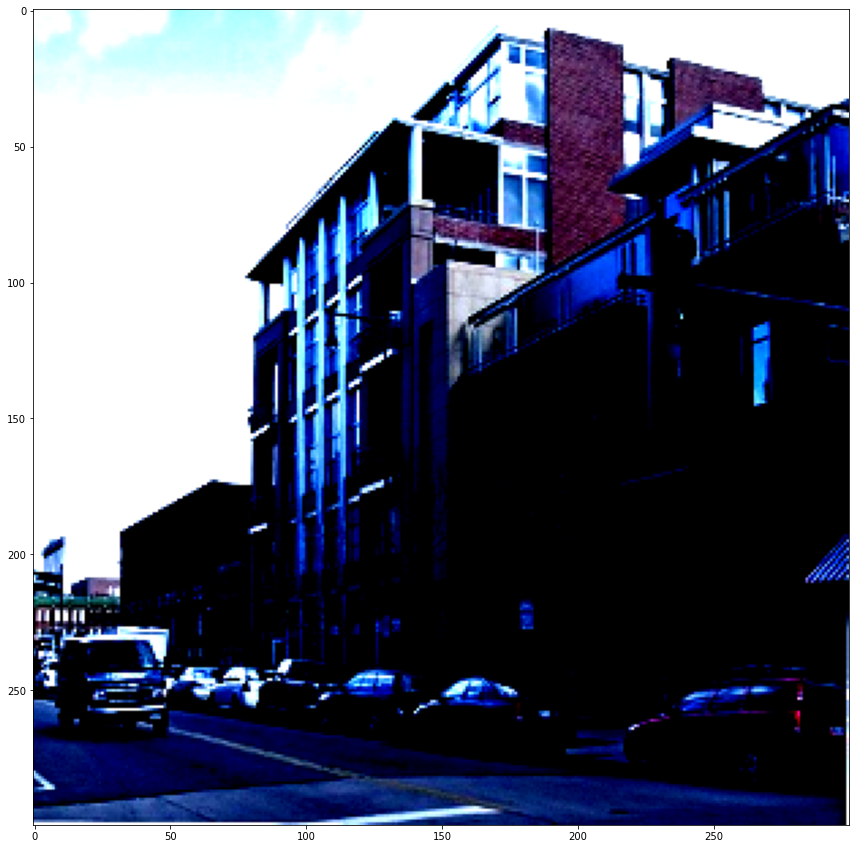

In [102]:
idx=3
TP, FP, FN = classify_boxes(det_boxes[idx:idx+1], det_labels[idx:idx+1], det_scores[idx:idx+1], true_boxes[idx:idx+1], true_labels[idx:idx+1])
print(len(TP)*2+ len(FP)+ len(FN), len(det_boxes[idx]) + len(true_boxes[idx]))
plot_image(test_dataset[idx][0], det_boxes[idx][TP[1]], FN)


In [98]:
from functools import reduce
len(TP)*2+ len(FP)+ len(FN), reduce(lambda count, l: count + len(l), det_boxes, 0) + reduce(lambda count, l: count + len(l), true_boxes, 0)

(31343, 31343)

In [114]:
det_scores

[tensor([0.7084, 0.9990], device='cuda:0'),
 tensor([0.9999], device='cuda:0'),
 tensor([0.], device='cuda:0'),
 tensor([0.9993, 0.9937, 0.8480, 0.7730, 0.7415, 0.5678, 0.2667],
        device='cuda:0'),
 tensor([0.7424, 0.5789, 0.4296, 0.4034, 0.9609, 0.3954, 0.2155],
        device='cuda:0'),
 tensor([0.9933], device='cuda:0'),
 tensor([0.9978, 0.9998, 0.2198], device='cuda:0'),
 tensor([0.9950, 0.2599, 0.2557], device='cuda:0'),
 tensor([0.9948], device='cuda:0'),
 tensor([0.9297, 0.9994, 0.3994, 0.5106, 0.2341], device='cuda:0'),
 tensor([0.9988, 0.3461], device='cuda:0'),
 tensor([0.9999, 0.2037], device='cuda:0'),
 tensor([0.9999, 0.9468], device='cuda:0'),
 tensor([0.5364, 0.3961, 0.2641, 0.5003, 0.9921, 0.9587, 0.8617, 0.8005, 0.6775,
         0.5461, 0.3745, 0.2652], device='cuda:0'),
 tensor([1.0000], device='cuda:0'),
 tensor([0.9944], device='cuda:0'),
 tensor([0.9999], device='cuda:0'),
 tensor([1.0000], device='cuda:0'),
 tensor([0.9998], device='cuda:0'),
 tensor([0.9994

In [115]:
correct = [1]*len(TP) + [0]*len(FP)
probs =[]
for img_idx,box_idx in TP+FP:
    probs.append(det_scores[img_idx][box_idx].item())
curves =[utils.metrics.compute_model_stats(correct, probs, "test")]

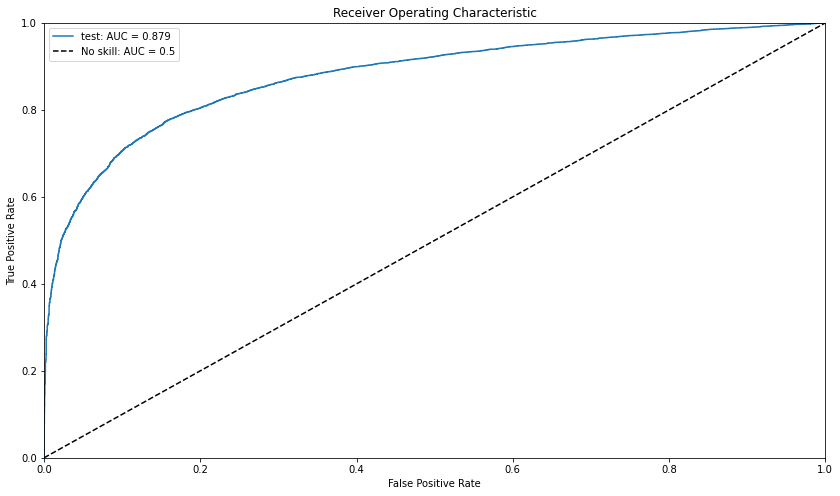

In [116]:
plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

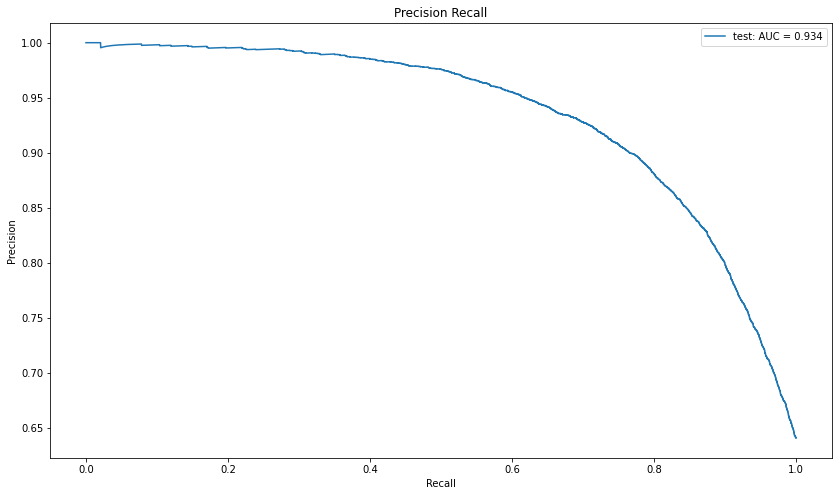

In [117]:
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [9]:
def bbox_dict_to_tensor(pred: dict):
    if "scores" not in pred:
        pred["scores"] = torch.ones_like(pred["labels"])
    return torch.cat((pred["labels"].unsqueeze(1), pred["scores"].unsqueeze(
        1), pred["boxes"]), 1).tolist()

In [10]:
class Observation:
    def __init__(self,bbox):
        self.bboxes= [bbox]
        self.mean = bbox
        self.prediction = bbox[1]
    
    def append(self, bbox):
        self.bboxes.append(bbox)
        self.mean = np.mean(self.bboxes, axis=0).tolist()

    def should_be_grouped(self, bbox, iou_threshold=0.95):
        if int(self.prediction) != int(bbox[1]):
            return False
        if utils.detection_metrics.intersection_over_union(torch.tensor(self.mean[3:]), torch.tensor(bbox[3:])) > iou_threshold:
            return True
        return False

    def __repr__(self):
        return f"{self.mean}, {len(self.bboxes)} bboxes combined"

def combine_boxes(preds):
    observations = []
    for i in preds:
        for bbox in i:
            grouped = False
            for observation in observations:
                if observation.should_be_grouped(bbox, iou_threshold=0.95):
                    observation.append(bbox)
                    grouped = True
                    break
            if not grouped:
                observations.append(Observation(bbox))
    return observations

        


In [ ]:


def validate_model(model, data_loader, device):
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []

    train_idx = 0
    progress_bar = tqdm(data_loader)
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()}
                    for t in targets]

        with torch.no_grad():
            out = model(images)
        for idx, pred in enumerate(out):
            bboxes = bbox_dict_to_tensor(pred)
            true_bboxes = bbox_dict_to_tensor(targets[idx])
            nms_boxes = utils.detection_metrics.nms(
                bboxes,
                iou_threshold=0.95,
                threshold=0.5,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes:
                # many will get converted to 0 pred
                # if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)
            train_idx += 1


def validate_model_mcd(model, data_loader, device, mcd_iters=20):
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []

    train_idx = 0
    progress_bar = tqdm(data_loader)
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()}
                    for t in targets]

        batch_preds = [[[] for j in range(mcd_iters)] for _ in range(len(images))]
        for i in range(20):
            with torch.no_grad():
                out = model(images)

            for idx, pred in enumerate(out):
                bboxes = bbox_dict_to_tensor(pred)
                true_bboxes = bbox_dict_to_tensor(targets[idx])
                nms_boxes = utils.detection_metrics.nms(
                    bboxes,
                    iou_threshold=0.95,
                    threshold=0.5,
                )

                for nms_box in nms_boxes:
                    batch_preds[idx].append([train_idx] + nms_box)

                for box in true_bboxes:
                    # many will get converted to 0 pred
                    # if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)
                train_idx += 1

    AP_50 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.5, num_classes=21)
    AP_75 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.75, num_classes=21)
    print(f'AP 50: {AP_50:.2f} AP 75: {AP_75:.2f}')
    return all_pred_boxes, all_true_boxes


pred_boxes, true_boxes = validate_model_mcd(
    model,  data_loader_test, device)

: 

In [21]:
type(true_boxes[1])

list

In [12]:
import matplotlib.patches as patches

def plot_image(image, boxes, gt_boxes):
    """Plots predicted bounding boxes on the image"""
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1,2,0))
    im = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        cls = box[1]
        confidence = box[2]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5*confidence,
            edgecolor="r",
            facecolor="none"
        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="r")
        # Add the patch to the Axes
        ax.add_patch(rect)

    for box in gt_boxes:
        cls = box[1]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=1,
            edgecolor="g",
            facecolor="none"

        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="g")

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [13]:
def correct_boxes(preds, gt, num_classes, iou_threshold=0.5):
    max_idx = gt[-1][0]
    TP = []
    FP = []
    FN = []

    pred_boxes_grouped = [ [] for _ in range(max_idx + 1) ]
    true_boxes_grouped = [ [] for _ in range(max_idx + 1) ]
    for box in preds:
        pred_boxes_grouped[box[0]].append(box)
    for box in gt:
        true_boxes_grouped[box[0]].append(box)

    for pred_boxes, true_boxes in zip(pred_boxes_grouped, true_boxes_grouped):
        pred_boxes.sort(key=lambda box: box[2], reverse=True)
        for pred_box_idx,pred_box in enumerate(pred_boxes[:]):
            best_iou = 0
            best_iou_idx = None
            for true_box_idx,true_box in enumerate(true_boxes):
                if true_box[1] == pred_box[1]:  
                    iou = utils.detection_metrics.intersection_over_union(
                        torch.tensor(pred_box[3:]), 
                        torch.tensor(true_box[3:]))
                    if iou > best_iou:
                        best_iou = iou
                        best_iou_idx = true_box_idx
            if best_iou > iou_threshold:
                TP.append(pred_box)
                true_boxes.remove(true_boxes[best_iou_idx])
                pred_boxes.remove(pred_box)
                   
        for box in pred_boxes:
            FP.append(box)
        for box in true_boxes:
            FN.append(box)
    return TP, FP, FN

AssertionError: Got more values than in x, y, w, h, in a box!

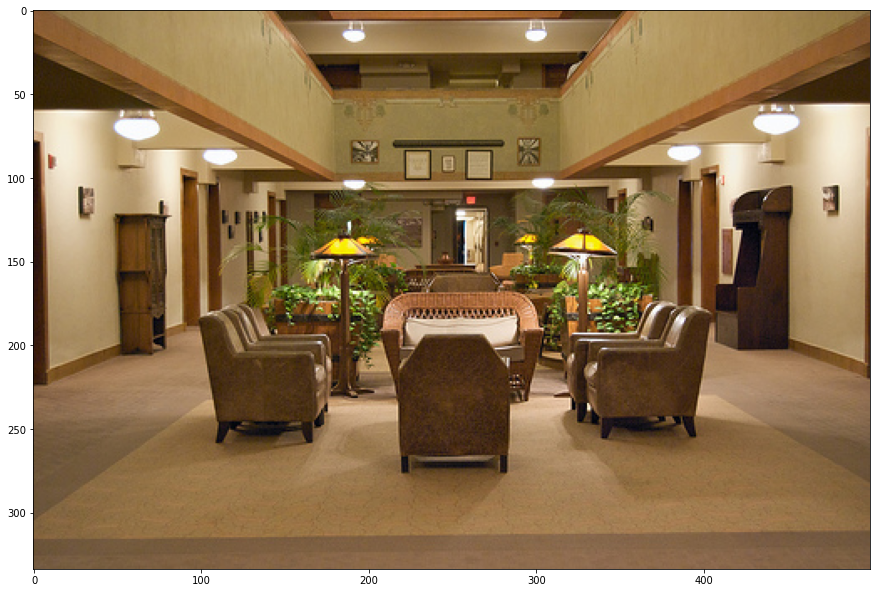

In [79]:
import random
utils.mc_dropout.set_training_mode_for_dropout(model, True)
# i = random.randint(0, len(data_test))
i=2545
preds = []
for _ in range(20):
    passes = []
    pred = model(data_test[i][0].unsqueeze(0).to(device))
    for img in pred:
        pred = bbox_dict_to_tensor(img)
        pred = utils.detection_metrics.nms(pred, 0.95, 0.5)
        passes.append(list(map(lambda box: [i] + box, pred)))
    preds.append(passes)
# preds = list(filter(lambda box: box[0]==i, pred_boxes))
# preds = utils.detection_metrics.nms(
#     preds,
#     iou_threshold=0.5,
#     threshold=0.5,
# )
gt = list(filter(lambda box: box[0]==i, true_boxes))
plot_image(data_test[i][0], preds[1], gt)

In [60]:
TP, FP, FN = correct_boxes(preds, gt, len(VOC_CLASSES))

In [62]:
len(TP), len(FP), len(FN)

(3, 2, 9)

In [83]:
len(preds[0][0])
        
        

11

In [48]:
preds[0][0],preds[1][0]

([2545,
  18.0,
  0.9310223460197449,
  209.9874267578125,
  152.3942413330078,
  308.5556335449219,
  233.34213256835938],
 [2545,
  18.0,
  0.752103328704834,
  214.66517639160156,
  158.68765258789062,
  312.5939025878906,
  238.76608276367188])

In [48]:
def combine_boxes(preds):
    observations = []
    for i in preds:
        for bbox in i:
            grouped = False
            for observation in observations:
                if observation.should_be_grouped(bbox, iou_threshold=0.95):
                    observation.append(bbox)
                    grouped = True
                    break
            if not grouped:
                observations.append(Observation(bbox))
    return observations

combined = combine_boxes(preds)
        

In [53]:
%lprun -f utils.detection_metrics.intersection_over_union combine_boxes(preds)

Timer unit: 1e-06 s

Total time: 0.033285 s
File: /home/jirka/uncertainty_estimations/utils/detection_metrics.py
Function: intersection_over_union at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def intersection_over_union(boxes_preds, boxes_labels):
     6                                               """
     7                                               Calculates intersection over union
     8                                               Parameters:
     9                                                   boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
    10                                                   boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
    11                                                   box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    12                                               Returns:
    13                      

In [179]:
combined_boxes = [box.mean for box in combined if box.mean[2] > .0 and len(box.bboxes) >= 10]

In [180]:
combined

[[2545.0, 18.0, 0.7907412383291457, 208.78304206000433, 163.27618662516275, 309.7829878065321, 236.16292232937283], 18 bboxes combined,
 [2545.0, 9.0, 0.6469690799713135, 219.9234535217285, 180.7207344055176, 291.6807693481445, 274.20208129882815], 20 bboxes combined,
 [2545.0, 9.0, 0.6824268348076764, 329.272902544807, 169.28854639389937, 403.8654085047105, 258.08900720932905], 17 bboxes combined,
 [2545.0, 9.0, 0.706149246957567, 103.33260515001085, 169.01627434624567, 179.1262681749132, 260.93546888563367], 9 bboxes combined,
 [2545.0, 16.0, 0.5987369894981385, 326.9172709147135, 157.04981384277343, 370.54856363932294, 194.25946146647135], 15 bboxes combined,
 [2545.0, 16.0, 0.600456964969635, 138.21630477905273, 162.72149887084962, 176.06670150756835, 190.09430541992188], 20 bboxes combined,
 [2545.0, 18.0, 0.5768574178218842, 320.61478000217016, 174.70047420925565, 410.3084530300564, 256.33854505750867], 18 bboxes combined,
 [2545.0, 16.0, 0.6306302882730961, 117.02509880065918, 1

In [63]:
plot_image(data_test[i][0], combined_boxes, [])

NameError: name 'combined_boxes' is not defined

In [65]:
utils.detection_metrics.mean_average_precision(pred_boxes, true_boxes, 0.9, 21)

tensor(0.6438)

In [32]:
res = [ [] for _ in range(pred_boxes[-1][0] + 1) ]
for box in pred_boxes:
    res[box[0]].append(box)


In [66]:
TP, FP, FN = correct_boxes(pred_boxes, true_boxes, len(VOC_CLASSES))


In [67]:
len(TP), len(FP), len(FN)

(10769, 3061, 5018)

In [94]:
det_boxes[0][1]

tensor([0.0187, 0.0078, 0.9949, 0.9959], device='cuda:0')

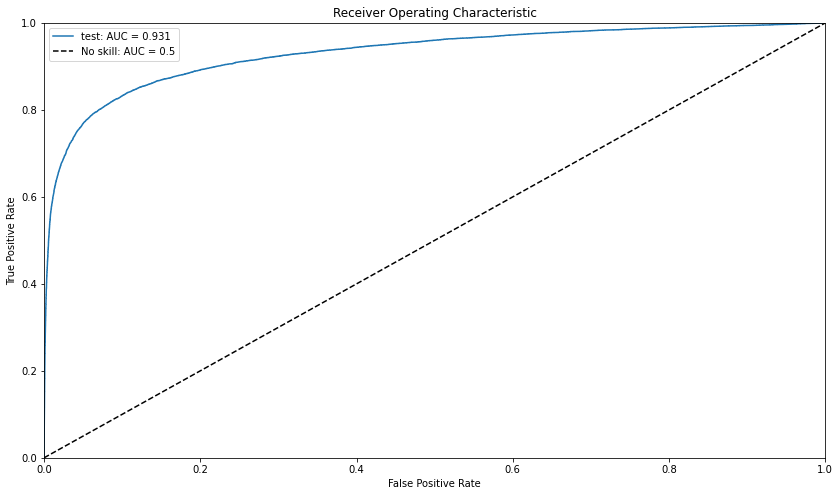

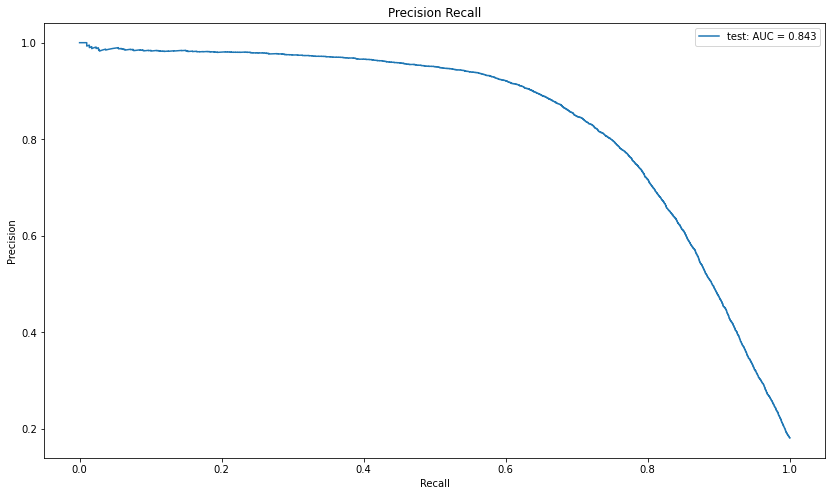